# 1️⃣ **Описание шаблона для решения задачи.**

**Задача**: обучить несколько бустингов на 3-х фолдах, выбрать лучшие, усреднить предсказания.

**Модели, которые будем обучать:**
- `CatBoostRegressor`
- `LightGBMRegressor (goss)`
- `XGBoostRegressor (dart)`


✅ Будут выполнены:
- все дополнительные условия
- возможности фреймворков (загрузка датасетов с помощью соответствующих классов, правильная подготовка категориальных признаков, early_stopping, многопоточность)
- подбор гиперпараметров для каждой модели

👀 При желании, рекомендуется проделать следующее:
- Провести EDA (Exploratory Data Analysis) и сделать выводы на основе графики
- Провести Feature Selection
- Провести Object Selection
- Использовать scheduler или custom callbacks
- Обучить дополнительные модели


❗️❗️❗️ **P.S.**
- Данный ноутбук - далеко не единственное верное решение, воспринимайте его как помощник для вашего собственного решения или чтобы побороть страх белого листа :)

- При полном заполнении ноутбука можно получить максимум 9 баллов из 10, так как из дополнительных баллов - только балл за подбор гиперпараметров.

- При любых найденных ошибках/опечатках/непонятных моментов в коде, пишите в [чат курса](https://stepik.org/lesson/681941/step/6?unit=680724)

# 2️⃣ **Подключение необходимых библиотек и загрузка данных.**

In [34]:
!pip install catboost lightgbm xgboost -q

In [35]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostRegressor, Pool

import lightgbm as lgb
from lightgbm import Dataset, LGBMRegressor

import xgboost as xgb
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [36]:
train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv')

In [37]:
RANDOM_STATE = 777

In [38]:
results = [] # Здесь будем хранить информацию по каждой модели

# 3️⃣ **Определим вспомогательные функции.**

In [39]:
def train_model(algorithm,
                X,
                y,
                early_stopping_rounds,
                init_params=None,
                cat_features=None,
                random_seed=2023
    ):
    scores = []
    models = []

    kf = KFold(n_splits=3, shuffle=True, random_state=random_seed)

    print(f"========= TRAINING {algorithm.__name__} =========")

    for num_fold, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_eval = X.iloc[train_index], X.iloc[val_index]
        y_train, y_eval = y.iloc[train_index], y.iloc[val_index]

        if init_params is not None:
            model = algorithm(**init_params)
        else:
            model = algorithm()



        if algorithm.__name__ == 'CatBoostRegressor':
            # Используйте соответствующий класс
            train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
            eval_dataset = Pool(data=X_eval, label=y_eval, cat_features=cat_features)

            model.fit(train_dataset,
                      eval_set=eval_dataset,
                      verbose=0,
                      early_stopping_rounds=early_stopping_rounds)

        elif algorithm.__name__ == 'LGBMRegressor':
            # Используйте соответствующий класс
            train_dataset = Dataset(X_train,
                                    y_train,
                                    free_raw_data=False,)
            eval_dataset = Dataset(X_eval,
                                   y_eval,
                                   free_raw_data=False,)

            model = lgb.train(params=init_params,
                              train_set=train_dataset,
                              valid_sets=(eval_dataset),
                              categorical_feature=cat_features)

        elif algorithm.__name__ == 'XGBRegressor':
            # Используйте соответствующий класс
            train_dataset = xgb.DMatrix(X_train,
                     label=y_train,
                     nthread=-1,
                     enable_categorical=True,)
            eval_dataset = xgb.DMatrix(X_eval,
                     label=y_eval,
                     nthread=-1,
                     enable_categorical=True,)

            model = xgb.train(params=init_params,
                              dtrain=train_dataset,
                              evals=[(train_dataset, 'dtrain'), (eval_dataset, 'dtest')],
                              verbose_eval=False,
                              early_stopping_rounds=early_stopping_rounds)

            X_eval = eval_dataset



        # Сделайте предсказание на X_eval и посчитайте RMSE
        y_pred = model.predict(X_eval)
        score = mean_squared_error(y_eval, y_pred)


        models.append(model)
        scores.append(score)

        print(f'FOLD {num_fold}: SCORE {score}')

    mean_kfold_score = np.mean(scores, dtype="float16") -  np.std(scores, dtype="float16")
    print("MEAN: ", np.mean(scores, dtype="float16"))
    print("\nMEAN RMSE SCORE", mean_kfold_score)

    # Выберите модель с наименьшим значением скора
    best_model = models[np.argmin(np.array(scores))]
    # print(best_model.get_params()) - для CatBoost
    # нельзя - для LightGBM
    #

    return mean_kfold_score, best_model

In [40]:
def tuning_hyperparams(algorithm,
                       X,
                       y,
                       init_params,
                       fit_params,
                       grid_params,
                       n_iter,
                       cv=3,
                       random_state=2023,
    ):

    estimator = algorithm(**init_params)

    # Можно использоавть GridSearchCV
    model = RandomizedSearchCV(estimator=estimator,
                               param_distributions=grid_params,
                               n_iter=n_iter,
                               cv=cv,
                               scoring='neg_root_mean_squared_error',
                               n_jobs=-1,
                               verbose=0,
                               random_state=random_state
    )

    model.fit(X, y, **fit_params)
    print(model.best_params_)
    print('-'*10)
    return model.best_params_ | init_params

# 4️⃣ **Группируем признаки, отбираем категориальные, выделяем датасет для обучения.**

In [41]:
cat_features = ['model', 'car_type', 'fuel_type', ]
targets = ["target_class", "target_reg"]
features2drop = ['car_id']

filtered_features = [i for i in train.columns if (i not in features2drop and i not in targets)]
num_features = [i for i in train.columns if i not in cat_features]


print("cat_features", cat_features)
print("num_features", num_features)
print("targets", targets)

cat_features ['model', 'car_type', 'fuel_type']
num_features ['car_id', 'car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'target_class', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq']
targets ['target_class', 'target_reg']


In [42]:
X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["target_reg"]

# 5️⃣ **CatBoostRegressor.**



## **Обучение модели.**

In [43]:
cb_init_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'thread_count': -1,
    'task_type': 'CPU',
    'random_seed': RANDOM_STATE
}

cb_score, cb_model = train_model(
    algorithm=CatBoostRegressor,  # model
    X=X, y=y,  # данные
    init_params=cb_init_params,  # params
    early_stopping_rounds=20,  # early STOP
    cat_features=cat_features,  # catecory
    random_seed=RANDOM_STATE  # RANDOM
)

========= TRAINING CatBoostRegressor =========
FOLD 0: SCORE 127.27186793805798
FOLD 1: SCORE 131.8285487064681
FOLD 2: SCORE 144.468067333495
MEAN:  134.5

MEAN RMSE SCORE 127.25


Сделаем предсказание для тестовой части и проверим скор на [лидерборде](https://stepik.org/lesson/779920/step/5?unit=782494)

In [44]:
test.drop(['target_class'], axis=1, inplace=True)
test_p = Pool(data=test.drop(['car_id'], axis=1), cat_features=cat_features)
# предсказываем
cb_test_pred = cb_model.predict(test_p)
pd.DataFrame({'car_id': test['car_id'], 'target_reg': cb_test_pred}).to_csv('cb_pred.csv', index=False)

In [45]:
results.append({
    'model_name': 'CatBoostRegressor',
    'tuning': False,
    'kfold_score': cb_score,
    'leaderboard_score': 11.9,
    'model': cb_model
})

## **Подбор гиперпараметров и обучение модели с новыми параметрами.**

In [46]:
cb_fit_params = {
    'cat_features': cat_features,
    'verbose': 0,
    'early_stopping_rounds': 5
}
cb_init_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'thread_count': -1,
    'task_type': 'CPU',
    'random_seed': RANDOM_STATE,
}


# Параметры, которые будем перебирать
cb_grid_params = {
    'iterations' : [1000], # Можно не перебирать, есть Early-Stopping
    'depth': [6,7,8,9,10],
    'learning_rate': [i*0.001 for i in range(1, 10)],
    'l2_leaf_reg': range(2, 50),
    'max_bin': [32,46,100,254],
    "colsample_bylevel": [i*0.01 for i in range(1, 80, 5)],
}


catboost_params_after_tuning = tuning_hyperparams(algorithm=CatBoostRegressor,
                                                  X=X, y=y,
                                                  init_params=cb_init_params,  # usual_param
                                                  fit_params=cb_fit_params,  # fit_param
                                                  grid_params=cb_grid_params,  # new_param
                                                  n_iter=3,
                                                  cv=3,
                                                  random_state=RANDOM_STATE
)

catboost_params_after_tuning

{'max_bin': 254, 'learning_rate': 0.005, 'l2_leaf_reg': 33, 'iterations': 1000, 'depth': 6, 'colsample_bylevel': 0.66}
----------


{'max_bin': 254,
 'learning_rate': 0.005,
 'l2_leaf_reg': 33,
 'iterations': 1000,
 'depth': 6,
 'colsample_bylevel': 0.66,
 'loss_function': 'RMSE',
 'eval_metric': 'MAE',
 'thread_count': -1,
 'task_type': 'CPU',
 'random_seed': 777}

In [47]:
cb_tuning_score, cb_tuning_model = train_model(algorithm=CatBoostRegressor,
                                               X=X, y=y,
                                               early_stopping_rounds=4,
                                               init_params=catboost_params_after_tuning,
                                               cat_features=cat_features,
                                               random_seed=RANDOM_STATE)

========= TRAINING CatBoostRegressor =========
FOLD 0: SCORE 140.33786817754049
FOLD 1: SCORE 140.82341555141207
FOLD 2: SCORE 161.09607731658366
MEAN:  147.5

MEAN RMSE SCORE 137.9


Сделаем предсказание для тестовой части и проверим скор на [лидерборде](https://stepik.org/lesson/779920/step/5?unit=782494)

In [48]:
tuning_cb_test_pred = cb_tuning_model.predict(test_p)

pd.DataFrame({'car_id': test['car_id'], 'target_reg': tuning_cb_test_pred}).to_csv('tuning_cb_pred.csv', index=False)

In [49]:
results.append({
    'model_name': 'CatBoostRegressor',
    'tuning': True,
    'mean_kfold_score': cb_tuning_score,
    'leaderboard_score': 11.9,
    'model': cb_tuning_model
})

# 6️⃣ **LightGBMRegressor (goss).**

## **Подготовка категориальных признаков.**

[Ссылка](https://github.com/a-milenkin/Competitive_Data_Science/blob/main/notebooks/4.2%20-%20LightGBM.ipynb), если забыли, как готовить категориальные признаки

In [50]:
X.shape

(2337, 14)

In [51]:
X_lgb = X.copy()

le = LabelEncoder()
for col in cat_features:
    X_lgb[col] = le.fit_transform(X[col])

## **Обучение модели.**

In [52]:
lgb_init_params = {
    'boosting_type': 'goss',
    'n_jobs': -1,
    'metric': 'RMSE',
    'objective': 'regression',
    'random_state': RANDOM_STATE,
    'verbosity': -1,
    'device': 'cpu',
}


lgb_score, lgb_model = train_model(
    algorithm=LGBMRegressor,
    X=X_lgb, y=y,
    init_params=lgb_init_params,
    early_stopping_rounds=5,
    cat_features=cat_features,
    random_seed=RANDOM_STATE
)

========= TRAINING LGBMRegressor =========
FOLD 0: SCORE 153.88287845454525
FOLD 1: SCORE 155.0024664088889
FOLD 2: SCORE 157.21967668483052
MEAN:  155.4

MEAN RMSE SCORE 154.0


Сделаем предсказание для тестовой части и проверим скор на [лидерборде](https://stepik.org/lesson/779920/step/5?unit=782494)

In [53]:
X_lgb_test = test.drop(['car_id'], axis=1).copy()

le = LabelEncoder()
for col in cat_features:
    X_lgb_test[col] = le.fit_transform(test[col])

In [54]:
lgb_test_pred = lgb_model.predict(X_lgb_test)

pd.DataFrame({'car_id': test['car_id'], 'target_reg': lgb_test_pred}).to_csv('lgb_pred.csv', index=False)

In [55]:
results.append({
    'model_name': 'LGBMRegressor (goss)',
    'tuning': False,
    'mean_kfold_score': lgb_score,
    'leaderboard_score': 12.6,
    'model': lgb_model
})

## **Подбор гиперпараметров и обучение модели с новыми параметрами**

In [56]:
lgb_fit_params = {
    'eval_metric': 'rmse',
    'categorical_feature': cat_features
}


lgb_grid_params = {
    'min_data_in_leaf': range(15, 25, 2),
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
    'num_leaves': [20, 30, 40],
    'max_bin': [255, 355, 455]
}


lgb_params_after_tuning = tuning_hyperparams(algorithm=LGBMRegressor,
                                             X=X_lgb, y=y,
                                             init_params=lgb_init_params,
                                             fit_params=lgb_fit_params,
                                             grid_params=lgb_grid_params,
                                             n_iter=100,
                                             cv=3,
                                             random_state=RANDOM_STATE
)

lgb_params_after_tuning

{'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 30, 'n_estimators': 200, 'min_data_in_leaf': 21, 'max_depth': 3, 'max_bin': 455, 'learning_rate': 0.05}
----------


{'reg_lambda': 0,
 'reg_alpha': 0,
 'num_leaves': 30,
 'n_estimators': 200,
 'min_data_in_leaf': 21,
 'max_depth': 3,
 'max_bin': 455,
 'learning_rate': 0.05,
 'boosting_type': 'goss',
 'n_jobs': -1,
 'metric': 'RMSE',
 'objective': 'regression',
 'random_state': 777,
 'verbosity': -1,
 'device': 'cpu'}

In [57]:
lgb_tuning_score, lgb_tuning_model = train_model(
    algorithm=LGBMRegressor,
    X=X_lgb, y=y,
    init_params=lgb_params_after_tuning,
    early_stopping_rounds=10,
    cat_features=cat_features,
    random_seed=RANDOM_STATE
)

========= TRAINING LGBMRegressor =========
FOLD 0: SCORE 135.20021813326474
FOLD 1: SCORE 142.9064894107325
FOLD 2: SCORE 152.93024406760435
MEAN:  143.6

MEAN RMSE SCORE 136.4


Сделаем предсказание для тестовой части и проверим скор на [лидерборде](https://stepik.org/lesson/779920/step/5?unit=782494)

In [58]:
tuning_lgb_test_pred = lgb_tuning_model.predict(X_lgb_test)

pd.DataFrame({'car_id': test['car_id'], 'target_reg': lgb_test_pred}).to_csv('lgb_tuning_pred.csv', index=False)

In [59]:
results.append({
    'model_name': 'LGBMRegressor (goss)',
    'tuning': True,
    'mean_kfold_score': lgb_tuning_score,
    'leaderboard_score': 12.0,
    'model': lgb_tuning_model
})

# 7️⃣ **XGBoostRegressor (dart).**

## **Подготовка категориальных признаков.**

[Ссылка](https://github.com/a-milenkin/Competitive_Data_Science/blob/main/notebooks/4.3%20-%20XGBoost.ipynb), если забыли, как готовить категориальные признаки

In [60]:
X_xgb = X.copy()

# Кат фичи преведем в тип 'category'
for col in cat_features:
    X_xgb[col] = X_xgb[col].astype('category')

## **Обучение модели.**

In [61]:
xgb_init_params = {
    'enable_categorical': True,
    'booster': 'dart',
    'objective': 'reg:squarederror',  # функции ошибки
    'eval_metric': 'rmse',
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbosity': 0,

    # параметры, которые обязательно объявить, чтобы модель работала в режиме dart
    'rate_drop': 0.1,
    'skip_drop': 0.3,
}


xgb_score, xgb_model = train_model(
    algorithm=XGBRegressor,
    X=X_xgb, y=y,
    init_params=xgb_init_params,
    early_stopping_rounds=10,
    cat_features=cat_features,
    random_seed=RANDOM_STATE
)

========= TRAINING XGBRegressor =========
FOLD 0: SCORE 144.2899318430392
FOLD 1: SCORE 147.84159988969193
FOLD 2: SCORE 157.87499526153877
MEAN:  150.0

MEAN RMSE SCORE 144.2


Сделаем предсказание для тестовой части и проверим скор на [лидерборде](https://stepik.org/lesson/779920/step/5?unit=782494)

In [62]:
test_xgb = test.drop(['car_id'], axis=1).copy()
for col in cat_features:
    test_xgb[col] = test_xgb[col].astype('category')
test_dataset = xgb.DMatrix(test_xgb,
                     nthread=-1,
                     enable_categorical=True,)
xgb_test_pred = xgb_model.predict(test_dataset) # YOUR CODE

pd.DataFrame({'car_id': test['car_id'], 'target_reg': xgb_test_pred}).to_csv('xgb_pred.csv', index=False)

In [63]:
results.append({
    'model_name': 'XGBRegressor (dart)',
    'tuning': False,
    'mean_kfold_score': xgb_score,
    'leaderboard_score': 12.4,
    'model': xgb_model
})

## **Подбор гиперпараметров и обучение модели с новыми параметрами**

In [66]:
xgb_grid_params = {
    'max_leaves': [10, 20, 30, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}


xgb_fit_params = {
    'verbose': False
}


xgb_params_after_tuning = tuning_hyperparams(algorithm=XGBRegressor,
                                             X=X_xgb, y=y,
                                             init_params=xgb_init_params,
                                             fit_params=xgb_fit_params,
                                             grid_params=xgb_grid_params,
                                             n_iter=10,
                                             cv=3,
                                             random_state=RANDOM_STATE
)

xgb_params_after_tuning

{'n_estimators': 200, 'min_child_weight': 3, 'max_leaves': 40, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}
----------


{'n_estimators': 200,
 'min_child_weight': 3,
 'max_leaves': 40,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 0.2,
 'colsample_bytree': 1.0,
 'enable_categorical': True,
 'booster': 'dart',
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'random_state': 777,
 'n_jobs': -1,
 'verbosity': 0,
 'rate_drop': 0.1,
 'skip_drop': 0.3}

In [67]:
xgb_tuning_score, xgb_tuning_model = train_model(
    algorithm=XGBRegressor,
    X=X_xgb, y=y,
    init_params=xgb_params_after_tuning,
    early_stopping_rounds=10,
    cat_features=cat_features,
    random_seed=RANDOM_STATE
)

========= TRAINING XGBRegressor =========
FOLD 0: SCORE 173.61503247301775
FOLD 1: SCORE 174.81162085217633
FOLD 2: SCORE 196.5973887333212
MEAN:  181.6

MEAN RMSE SCORE 171.0


In [68]:
tuning_xgb_test_pred = xgb_tuning_model.predict(test_dataset) # YOUR CODE
pd.DataFrame({'car_id': test['car_id'], 'target_reg': tuning_xgb_test_pred}).to_csv('tuning_xgb_pred.csv', index=False)

In [69]:
results.append({
    'model_name': 'XGBRegressor (dart)',
    'tuning': True,
    'mean_kfold_score': xgb_tuning_score,
    'leaderboard_score': 13.3,
    'model': xgb_tuning_model
})

# 8️⃣ **Финальное предсказание и сохранение лучших моделей**

In [70]:
best_cb_model = cb_tuning_model
best_cb_model.save_model('best_cb_model.cbm')

best_lgb_model = lgb_tuning_model
best_lgb_model.save_model('best_lgb_model.mod')


best_xgb_model = xgb_model
best_xgb_model.save_model('best_xgb_model.json')

In [71]:
final_cb_pred = tuning_cb_test_pred
final_lgb_pred = tuning_lgb_test_pred
final_xgb_pred = xgb_test_pred

final_pred = (final_cb_pred + final_lgb_pred + final_xgb_pred) / 3

pd.DataFrame({'car_id': test['car_id'], 'target_reg': final_pred}).to_csv('final_submission.csv', index=False)

In [72]:
results.append({
    'model_name': 'all_models',
    'tuning': True,
    'mean_kfold_score': 12,
    'leaderboard_score': 11.9,
    'model': None
})

# 9️⃣ **Выводы.**


In [73]:
results = pd.DataFrame(results)
results

,model_name,tuning,kfold_score,leaderboard_score,model,mean_kfold_score
0,CatBoostRegressor,False,127.25,11.9,<catboost.core.CatBoostRegressor object at 0x7...,NaN
1,CatBoostRegressor,True,NaN,11.9,<catboost.core.CatBoostRegressor object at 0x7...,137.875
2,LGBMRegressor (goss),False,NaN,12.6,<lightgbm.basic.Booster object at 0x7d8b4ac72410>,154.000
3,LGBMRegressor (goss),True,NaN,12.0,<lightgbm.basic.Booster object at 0x7d8b4ac72aa0>,136.375
4,XGBRegressor (dart),False,NaN,12.4,<xgboost.core.Booster object at 0x7d8b4ac72fe0>,144.250
5,XGBRegressor (dart),True,NaN,13.3,<xgboost.core.Booster object at 0x7d8b4ac42c80>,171.000
6,all_models,True,NaN,11.9,None,12.000


**Вывод:**
- CatBoostRegressor показал самый лучший результат, как и бэггинг 3 моделей
- Перебрав несколько параметров, тюнинг гиперпараметров никак не прибавил score (что удивительно)

# Дополнительно

### Графики в студию

In [74]:
import seaborn as sns

In [75]:
train.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,3.880920,1.651883e+07,0.1,172.793237,-5.029476,174,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,4.181149,1.398317e+07,0.1,203.462289,-14.260456,174,171


In [76]:
sns.set_palette("crest")
sns.set(rc={'figure.figsize':(6.7,4.27)})

<Axes: xlabel='fuel_type', ylabel='mean_target_reg'>

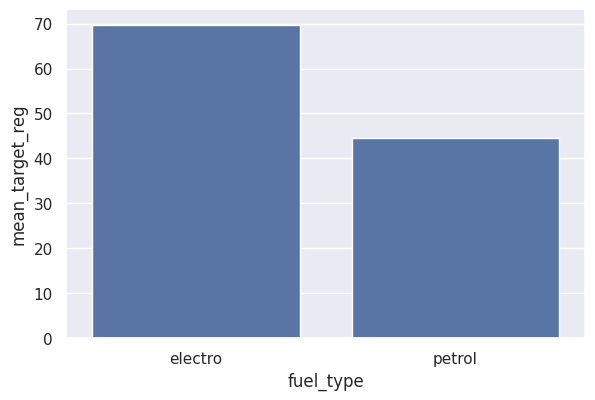

In [77]:
mean_reg = train.groupby('fuel_type', as_index=False).agg(mean_target_reg = ('target_reg', 'mean'))
sns.barplot(x='fuel_type', y='mean_target_reg', data=mean_reg, errwidth=0, )

> Авто с типом топлива **electro** живут дольше (может из за маленького кол-ва)

In [78]:
train['fuel_type'].value_counts()

petrol     2289
electro      48
Name: fuel_type, dtype: int64

<Axes: xlabel='car_type', ylabel='mean_target_reg'>

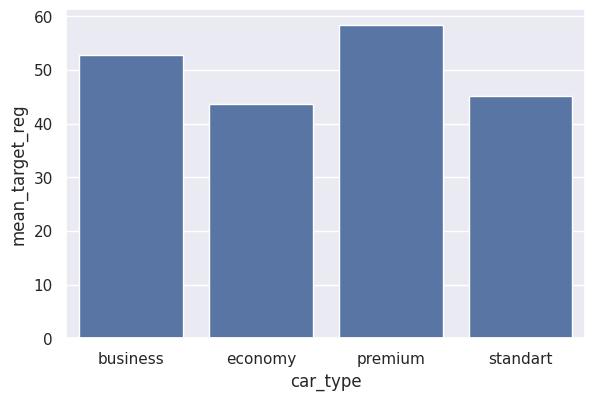

In [79]:
mean_reg = train.groupby('car_type', as_index=False).agg(mean_target_reg = ('target_reg', 'mean'))
sns.barplot(x='car_type', y='mean_target_reg', data=mean_reg, errwidth=0, )

> Economy ломается быстро, Premium живет дольше

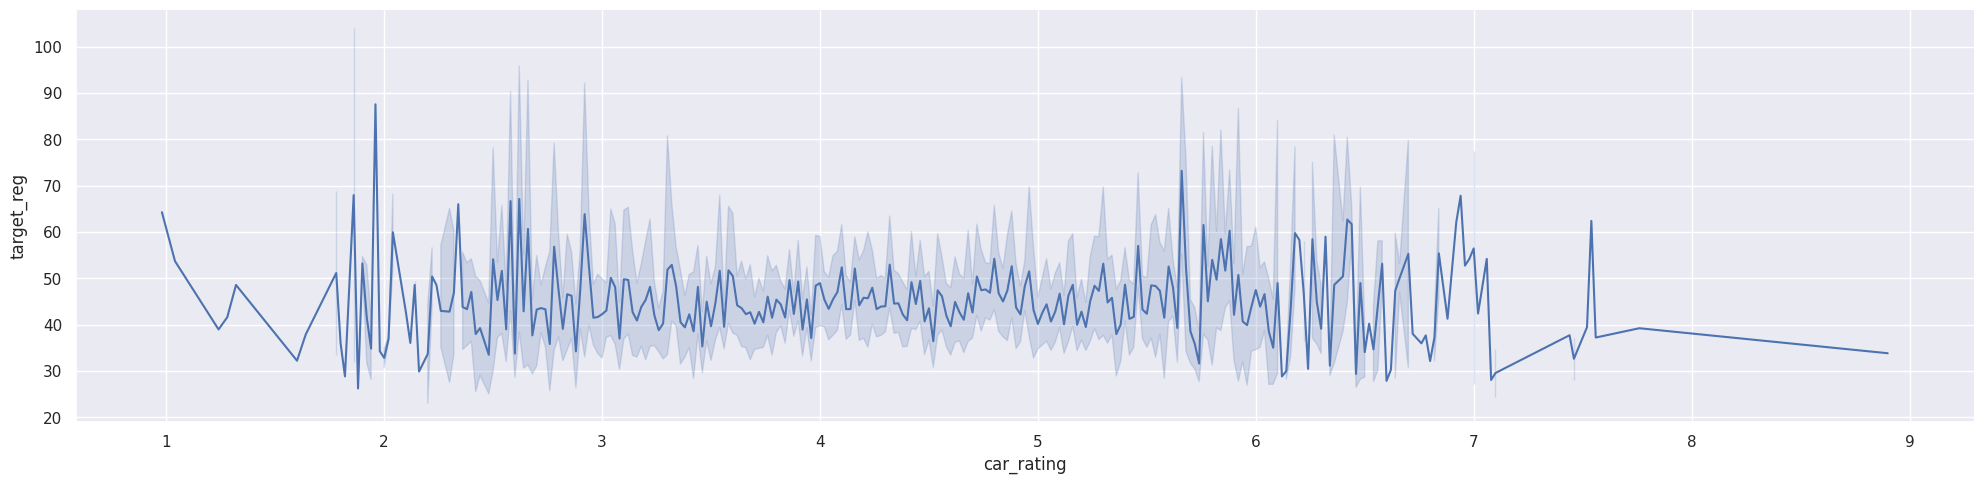

In [80]:
sns.relplot(data=train, x='car_rating', y='target_reg', legend=True, kind="line", aspect=4)

<Axes: xlabel='how_year', ylabel='promt'>

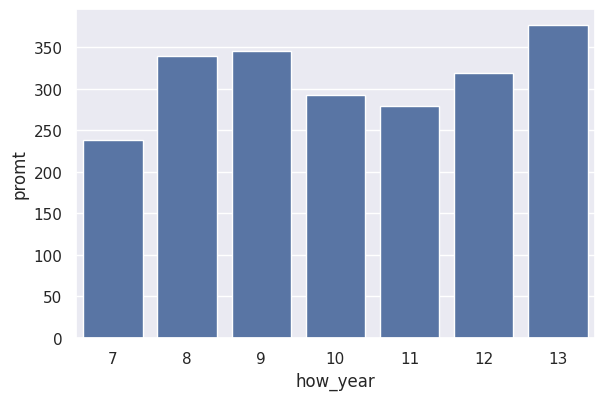

In [81]:
pp = lambda x: x.var()

train['how_year'] = train.year_to_start.apply(lambda x: 2024-x)
var_reg = train.groupby('how_year', as_index=False).agg(promt = ('target_reg', pp))
sns.barplot(x='how_year', y='promt', data=var_reg, errwidth=0)

> Изоброзив график с **дисперсией** [2024 - year_to_start] можем понять, что машины с большим стажем наиболее отличы между собой

## CatBoost

### Feature Selection?

In [82]:
!pip install phik -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 7.4 MB/s eta 0:00:00


In [83]:
import phik
from phik.report import plot_correlation_matrix
from phik import report
import matplotlib.pyplot as plt

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq', 'how_year']


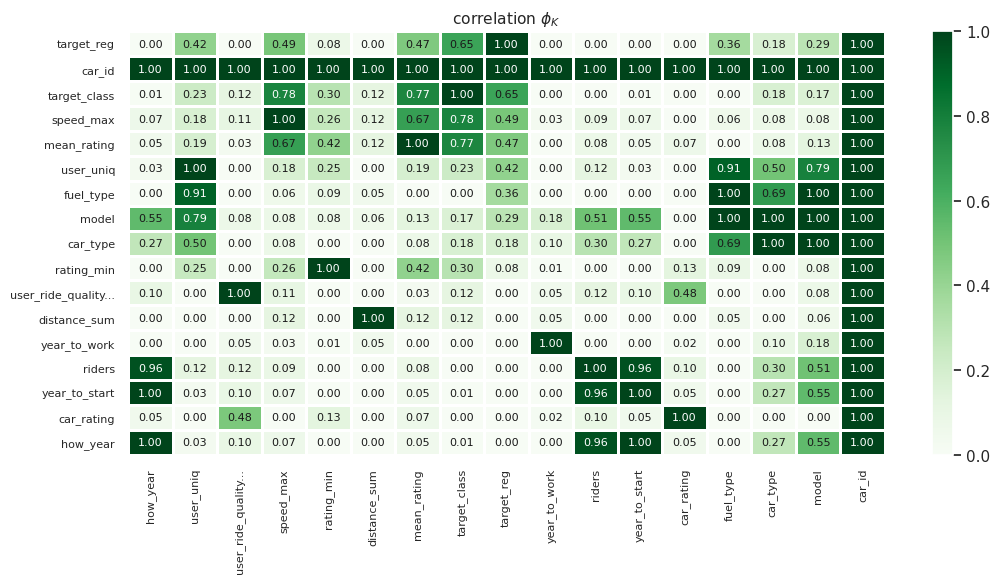

In [84]:
phik_overview = train.phik_matrix().round(2).sort_values('target_reg')

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

> Наиболее карелирующие колонки: **'user_uniq', 'speed_max', 'mean_rating'**

In [85]:
!pip install catboost shap -q
import shap
shap.initjs()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.3 MB/s eta 0:00:00


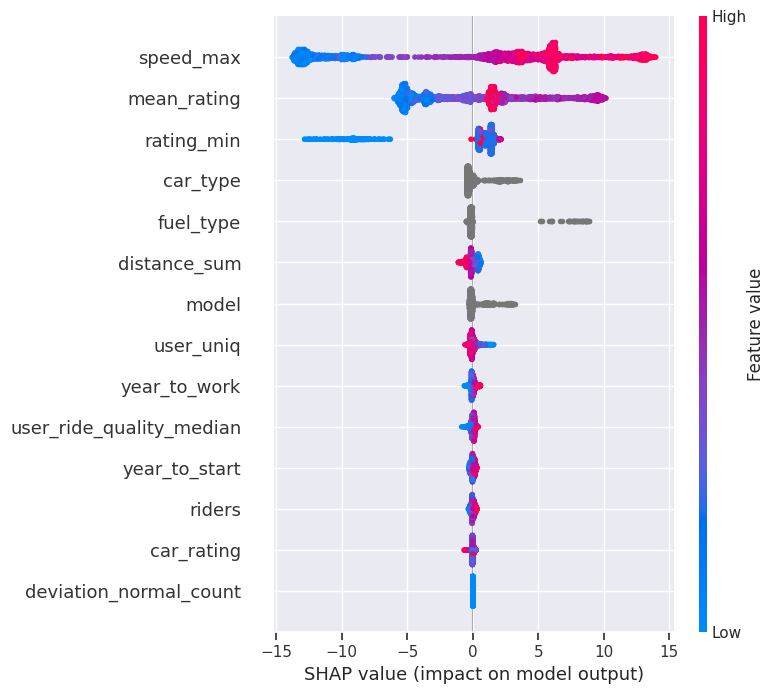

In [86]:
# Посмотрим на SHAP values
explainer = shap.TreeExplainer(cb_tuning_model)

val_dataset = Pool(data=X, label=y, cat_features=cat_features)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X, max_display = 25)

> Много ненужных колонок, с которыми можно разобраться

In [87]:
!pip install boruta -q

from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.5 MB/s eta 0:00:00


In [88]:
from sklearn.ensemble import RandomForestClassifier

In [89]:
modifide = X.copy()

le = LabelEncoder()
for col in cat_features:
    modifide[col] = le.fit_transform(X[col])

In [90]:
###initialize Boruta
forest = RandomForestRegressor(
   n_jobs = -1,
   max_depth = 3
)
boruta = BorutaPy(
   estimator = forest,
   n_estimators = 'auto',
   max_iter = 8, # number of trials to perform
    verbose=1
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(modifide), np.array(y))
### print results
green_area = modifide.columns[boruta.support_].to_list()
blue_area = modifide.columns[boruta.support_weak_].to_list()
red_area = modifide.columns[~(boruta.support_ | boruta.support_weak_)].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)
print('features in the red area:', red_area)

Iteration: 1 / 8
Iteration: 2 / 8
Iteration: 3 / 8
Iteration: 4 / 8
Iteration: 5 / 8
Iteration: 6 / 8
Iteration: 7 / 8


BorutaPy finished running.

Iteration: 	8 / 8
Confirmed: 	0
Tentative: 	7
Rejected: 	0
features in the green area: []
features in the blue area: ['model', 'fuel_type', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_uniq']
features in the red area: ['car_type', 'car_rating', 'year_to_start', 'riders', 'year_to_work', 'user_ride_quality_median', 'deviation_normal_count']


In [91]:
test_del_X = X.drop(['car_type', 'car_rating', 'year_to_start', 'riders', 'year_to_work', 'user_ride_quality_median', 'deviation_normal_count'], axis=1)
init_params = ['mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_uniq']
cat_features = ['model', 'fuel_type']

cb_score, cb_model = train_model(
    algorithm=CatBoostRegressor,  # model
    X=test_del_X, y=y,  # данные
    init_params=cb_init_params,  # params
    early_stopping_rounds=20,  # early STOP
    cat_features=cat_features,  # catecory
    random_seed=RANDOM_STATE  # RANDOM
)

========= TRAINING CatBoostRegressor =========
FOLD 0: SCORE 128.2199605775863
FOLD 1: SCORE 128.6077574261945
FOLD 2: SCORE 146.88027325964316
MEAN:  134.6

MEAN RMSE SCORE 125.94


> Удалим колонки из красной зонны -> обучим CatBoost

In [92]:
test_X = test[['car_id', 'model', 'fuel_type', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_uniq']]
test_p = Pool(data=test_X.drop(['car_id'], axis=1), cat_features=cat_features)
# предсказываем
cb_test_pred = cb_model.predict(test_p)
pd.DataFrame({'car_id': test['car_id'], 'target_reg': cb_test_pred}).to_csv('boruta_work.csv', index=False)

> Вы побили порог в 12 RMSE: ваше решение дает RMSE=11.8. Двигайтесь дальше!